This notebook shows how to use the adapter merging methods from `peft` and apply them image generation models using `diffusers`.

## Turn `diffusers` LoRA checkpoints into `PeftModel`

In [ ]:
!pip install diffusers accelerate transformers -U -q
!pip install git+https://github.com/huggingface/peft -q

In [ ]:
from google.colab import userdata
TOKEN = userdata.get("HF_TOKEN")

In [ ]:
from diffusers import UNet2DConditionModel
import torch

device = torch.accelerator.current_accelerator().type if hasattr(torch, "accelerator") else "cuda"

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to(device)

In [3]:
# So that we can populate it later.
import copy

sdxl_unet = copy.deepcopy(unet)

In [4]:
# Load the pipeline too.
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    model_id, variant="fp16", torch_dtype=torch.float16, unet=unet
).to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.25it/s]


In [ ]:
# Only UNet
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

In [6]:
from peft import get_peft_model, LoraConfig

toy_peft_model = get_peft_model(
    sdxl_unet,
    pipe.unet.peft_config["toy"],
    adapter_name="toy"
)

In [ ]:
original_state_dict = {f"base_model.model.{k}": v for k, v in pipe.unet.state_dict().items()}

toy_peft_model.load_state_dict(original_state_dict, strict=True)
toy_peft_model.push_to_hub("toy_peft_model-new", token=TOKEN)

In [8]:
pipe.delete_adapters("toy")
sdxl_unet.delete_adapters("toy")

In [ ]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters(adapter_names="pixel")

In [ ]:
pixel_peft_model = get_peft_model(
    sdxl_unet,
    pipe.unet.peft_config["pixel"],
    adapter_name="pixel"
)

original_state_dict = {f"base_model.model.{k}": v for k, v in pipe.unet.state_dict().items()}
pixel_peft_model.load_state_dict(original_state_dict, strict=True)
pixel_peft_model.push_to_hub("pixel_peft_model-new", token=TOKEN)

In [11]:
del pipe, sdxl_unet, toy_peft_model, pixel_peft_model

## Weighted adapter inference

In [12]:
from peft import PeftModel

base_unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to(device)

toy_id = "sayakpaul/toy_peft_model-new"
model = PeftModel.from_pretrained(base_unet, toy_id, use_safetensors=True, subfolder="toy", adapter_name="toy")
model.load_adapter("sayakpaul/pixel_peft_model-new", use_safetensors=True, subfolder="pixel", adapter_name="pixel")

# https://huggingface.co/docs/peft/main/en/package_reference/lora#peft.LoraModel.add_weighted_adapter
model.add_weighted_adapter(
    adapters=["toy", "pixel"],
    weights=[0.7, 0.3],
    combination_type="linear",
    adapter_name="toy-pixel"
)
model.set_adapters("toy-pixel")

In [13]:
type(model.base_model.model)

diffusers.models.unets.unet_2d_condition.UNet2DConditionModel

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 21.14it/s]
Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.
100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


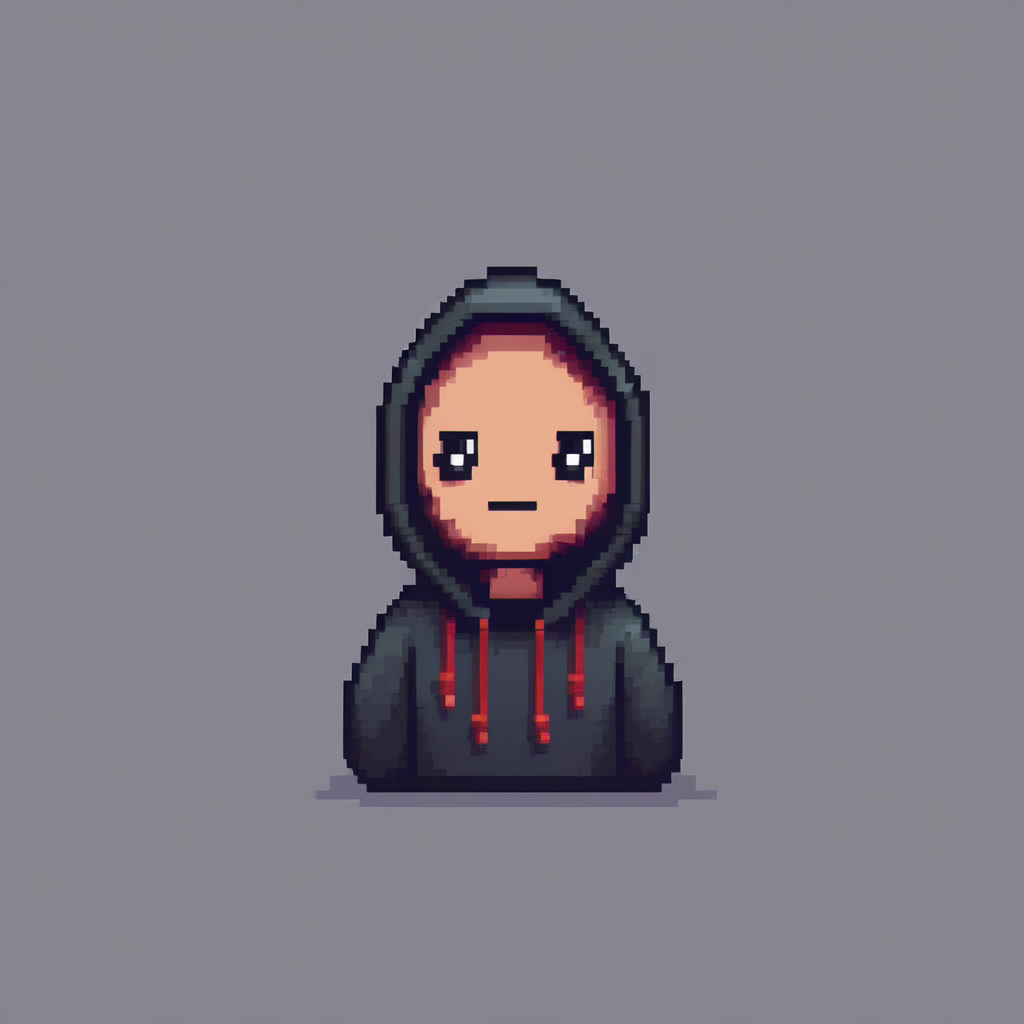

In [14]:
model = model.to(torch_dtype=torch.float16, device=device)

pipe = DiffusionPipeline.from_pretrained(
    model_id, unet=model, variant="fp16", torch_dtype=torch.float16,
).to(device)

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

In [15]:
del pipe

In [16]:
base_unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet", torch_dtype=torch.float16, use_safetensors=True, variant="fp16"
).to(device)

toy_id = "sayakpaul/toy_peft_model-new"
model = PeftModel.from_pretrained(base_unet, toy_id, use_safetensors=True, subfolder="toy", adapter_name="toy")
model.load_adapter("sayakpaul/pixel_peft_model-new", use_safetensors=True, subfolder="pixel", adapter_name="pixel")

# https://huggingface.co/docs/peft/main/en/package_reference/lora#peft.LoraModel.add_weighted_adapter
model.add_weighted_adapter(
    adapters=["toy", "pixel"],
    weights=[0.5, 0.5],
    combination_type="cat",
    adapter_name="toy-pixel"
)
model.set_adapters("toy-pixel")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 19.85it/s]
Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.
100%|██████████| 30/30 [00:05<00:00,  5.35it/s]


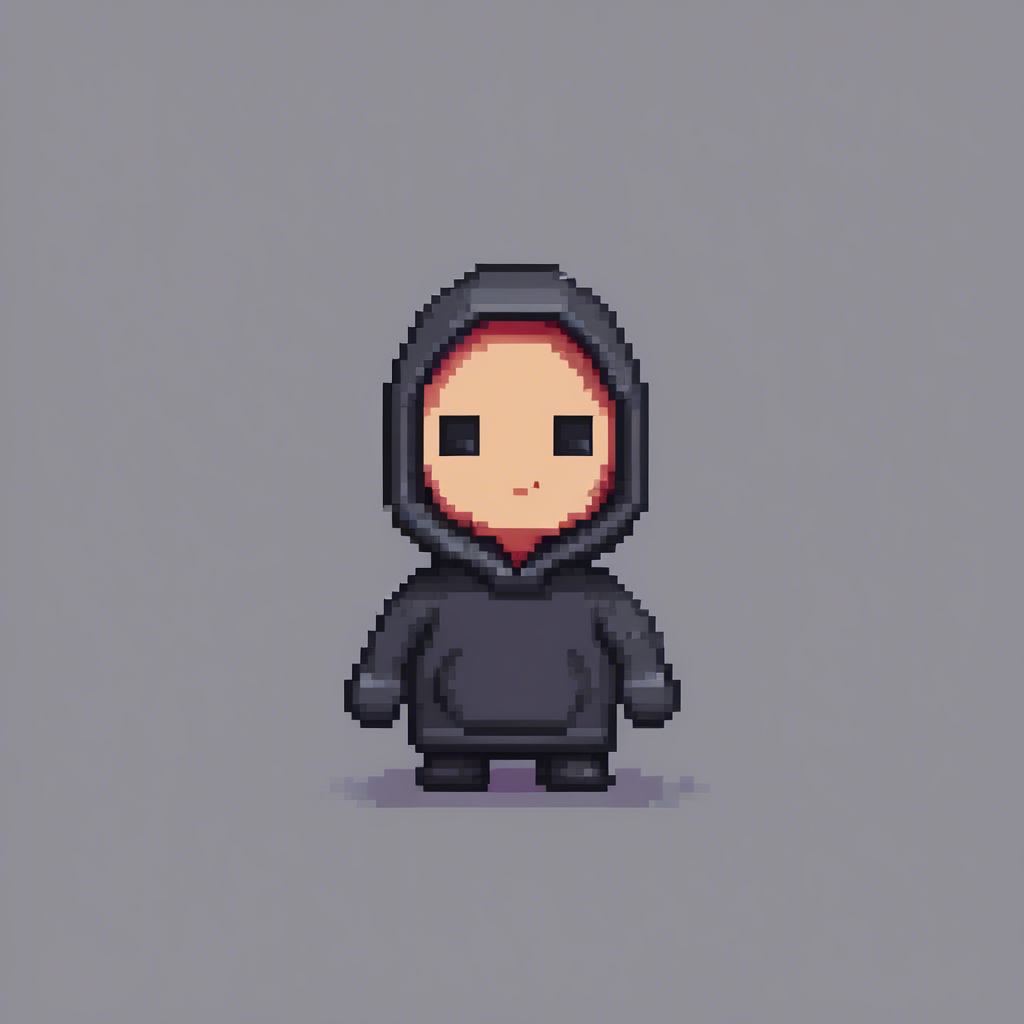

In [17]:
model = model.to(torch_dtype=torch.float16, device=device)

pipe = DiffusionPipeline.from_pretrained(
   model_id, unet=model, variant="fp16", torch_dtype=torch.float16,
).to(device)

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

100%|██████████| 30/30 [00:03<00:00,  9.26it/s]


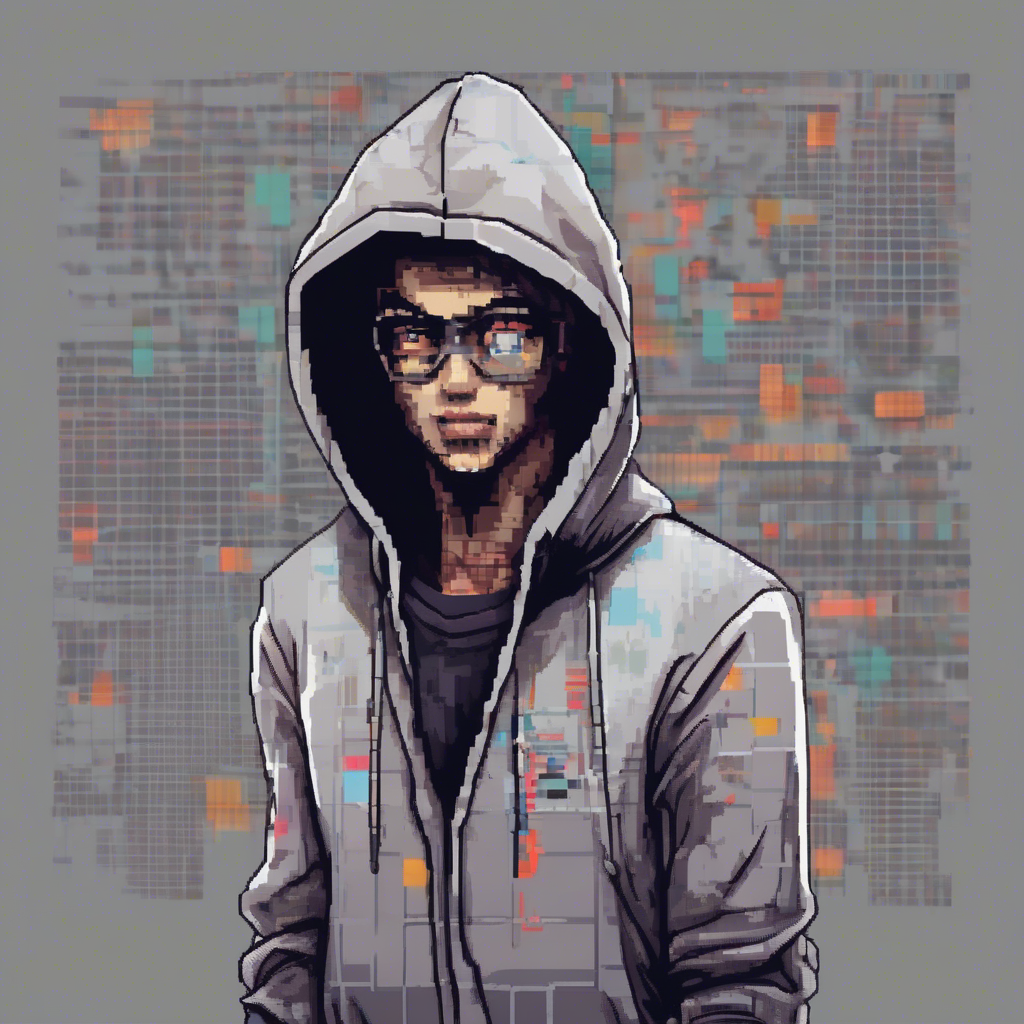

In [18]:
del pipe

pipe = DiffusionPipeline.from_pretrained(
    model_id, variant="fp16", dtype=torch.float16,
).to(device)

prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image